In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

In [2]:
def _zero_out_utrs(y):
    # copied from HelixerSequence due to an import error
    y[..., 0] = np.logical_or(y[..., 0], y[..., 1])
    y[..., 1] = 0

In [3]:
def cross_entropy(y_true, y_pred):
    true_class_preds = y_pred[y_true.astype(np.bool)]
    losses = -np.log(true_class_preds)
    return losses

In [4]:
def dna_sequence(y):
    letters = 'CATG'
    sequence = ''.join([letters[idx] for idx in np.nonzero(y)[1]])
    return sequence

In [5]:
# f = h5py.File('/home/felix/Desktop/helixer/data/plants/nine_genomes_nosplit_tmp/training_data.h5', 'r')

f = h5py.File('/home/felix/Desktop/helixer/data/plants/single_genomes/Crubella/test_data.h5', 'r')
p = h5py.File('/home/felix/Desktop/crubella_tests/crubella_predictions.h5', 'r')

In [7]:
X = f['data/X']
y_true = f['data/y']
sw = f['data/sample_weights']
seqids = f['data/seqids'][:]
species = f['data/species'][:]
start_ends = f['data/start_ends'][:]
y_true_phase = f['data/phases'][:]

y_pred = p['/predictions']
y_pred_phase = p['/predictions_phase']
print(f'{X.shape=}, {y_true.shape=}, {y_pred.shape=}, {y_pred_phase.shape=}, {sw.shape=}')

X.shape=(14754, 20000, 4), y_true.shape=(14754, 20000, 4), y_pred.shape=(14754, 20000, 4), y_pred_phase.shape=(14754, 20000, 4), sw.shape=(14754, 20000)


In [36]:
idx = 1528
y_pred[idx][-3:]
# cross_entropy(y_true[idx], y_pred[idx])

array([[0.8906 , 0.01247, 0.0795 , 0.01735],
       [0.     , 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     ]], dtype=float16)

In [47]:
losses = np.zeros(y_true.shape[0], dtype=np.float32)
losses_phase = np.zeros(y_true.shape[0], dtype=np.float32)
frac_sw = np.zeros(y_true.shape[0], dtype=np.float32)  # fraction of sample weights in non-padding regions

chunk_size = 10000
overhang = np.count_nonzero(np.all(y_pred[0] == 0, axis=-1))  # overhang is when all predictions are 0.0 in that base
print(f'{overhang=}')
for offset in range(0, y_true.shape[0], chunk_size):
    chunk_slice = (slice(offset, offset + chunk_size), slice(None, -overhang))
    y_true_chunk, y_pred_chunk, sw_chunk = y_true[chunk_slice], y_pred[chunk_slice], sw[chunk_slice]
    y_true_phase_chunk, y_pred_phase_chunk = y_true_phase[chunk_slice], y_pred_phase[chunk_slice]  
    
    # remove utr column
    # _zero_out_utrs(y_true_chunk)
    # y_true_chunk = np.delete(y_true_chunk, 1, axis=-1)
    # y_pred_chunk = np.delete(y_pred_chunk, 1, axis=-1)
    
    # calculate losses for each sample individually due to padding
    # sample weights are not taken into account
    for i in range(len(y_true_chunk)):
        y_true_sample, y_pred_sample, sw_sample = y_true_chunk[i], y_pred_chunk[i], sw_chunk[i]
        losses[offset + i] = np.mean(cross_entropy(y_true_sample, y_pred_sample))
        
        y_true_phase_sample, y_pred_phase_sample = y_true_phase_chunk[i], y_pred_phase_chunk[i]  
        losses_phase[offset + i] = np.mean(cross_entropy(y_true_phase_sample, y_pred_phase_sample))
        
        n_genetic_bases = np.count_nonzero(y_true_sample)
        frac_sw[offset + i] = 1 - (np.count_nonzero(sw_sample) / n_genetic_bases)
    print(f'calculated losses for offset {offset + chunk_size} / {y_true.shape[0]}')

overhang=2
calculated losses for offset 10000 / 14754
calculated losses for offset 20000 / 14754


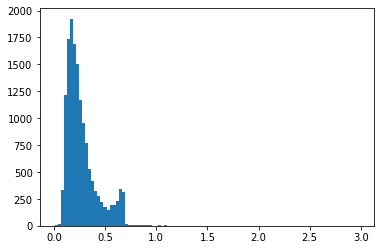

In [55]:
plt.hist(losses_phase, bins=100)
plt.show()

In [99]:
unique_species = np.unique(species)
print(unique_species)

loss_idxs, loss_phase_idxs = {}, {}
loss_idxs['all'], loss_phase_idxs['all'] = np.argsort(losses), np.argsort(losses_phase)
for name in unique_species:
    species_idx = np.argwhere(species == name).ravel()
    loss_idxs[name.decode()] = [i for i in loss_idxs['all'] if i in species_idx]
    print(name, len(loss_idxs[name.decode()]))

[b'Crubella']
b'Crubella' 14754


In [100]:
# sample weight color map
cmap = colors.ListedColormap(['red', 'white'])
bounds=[0, 0.5, 1.0]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.rc('axes', labelsize=30)

<AxesSubplot:>

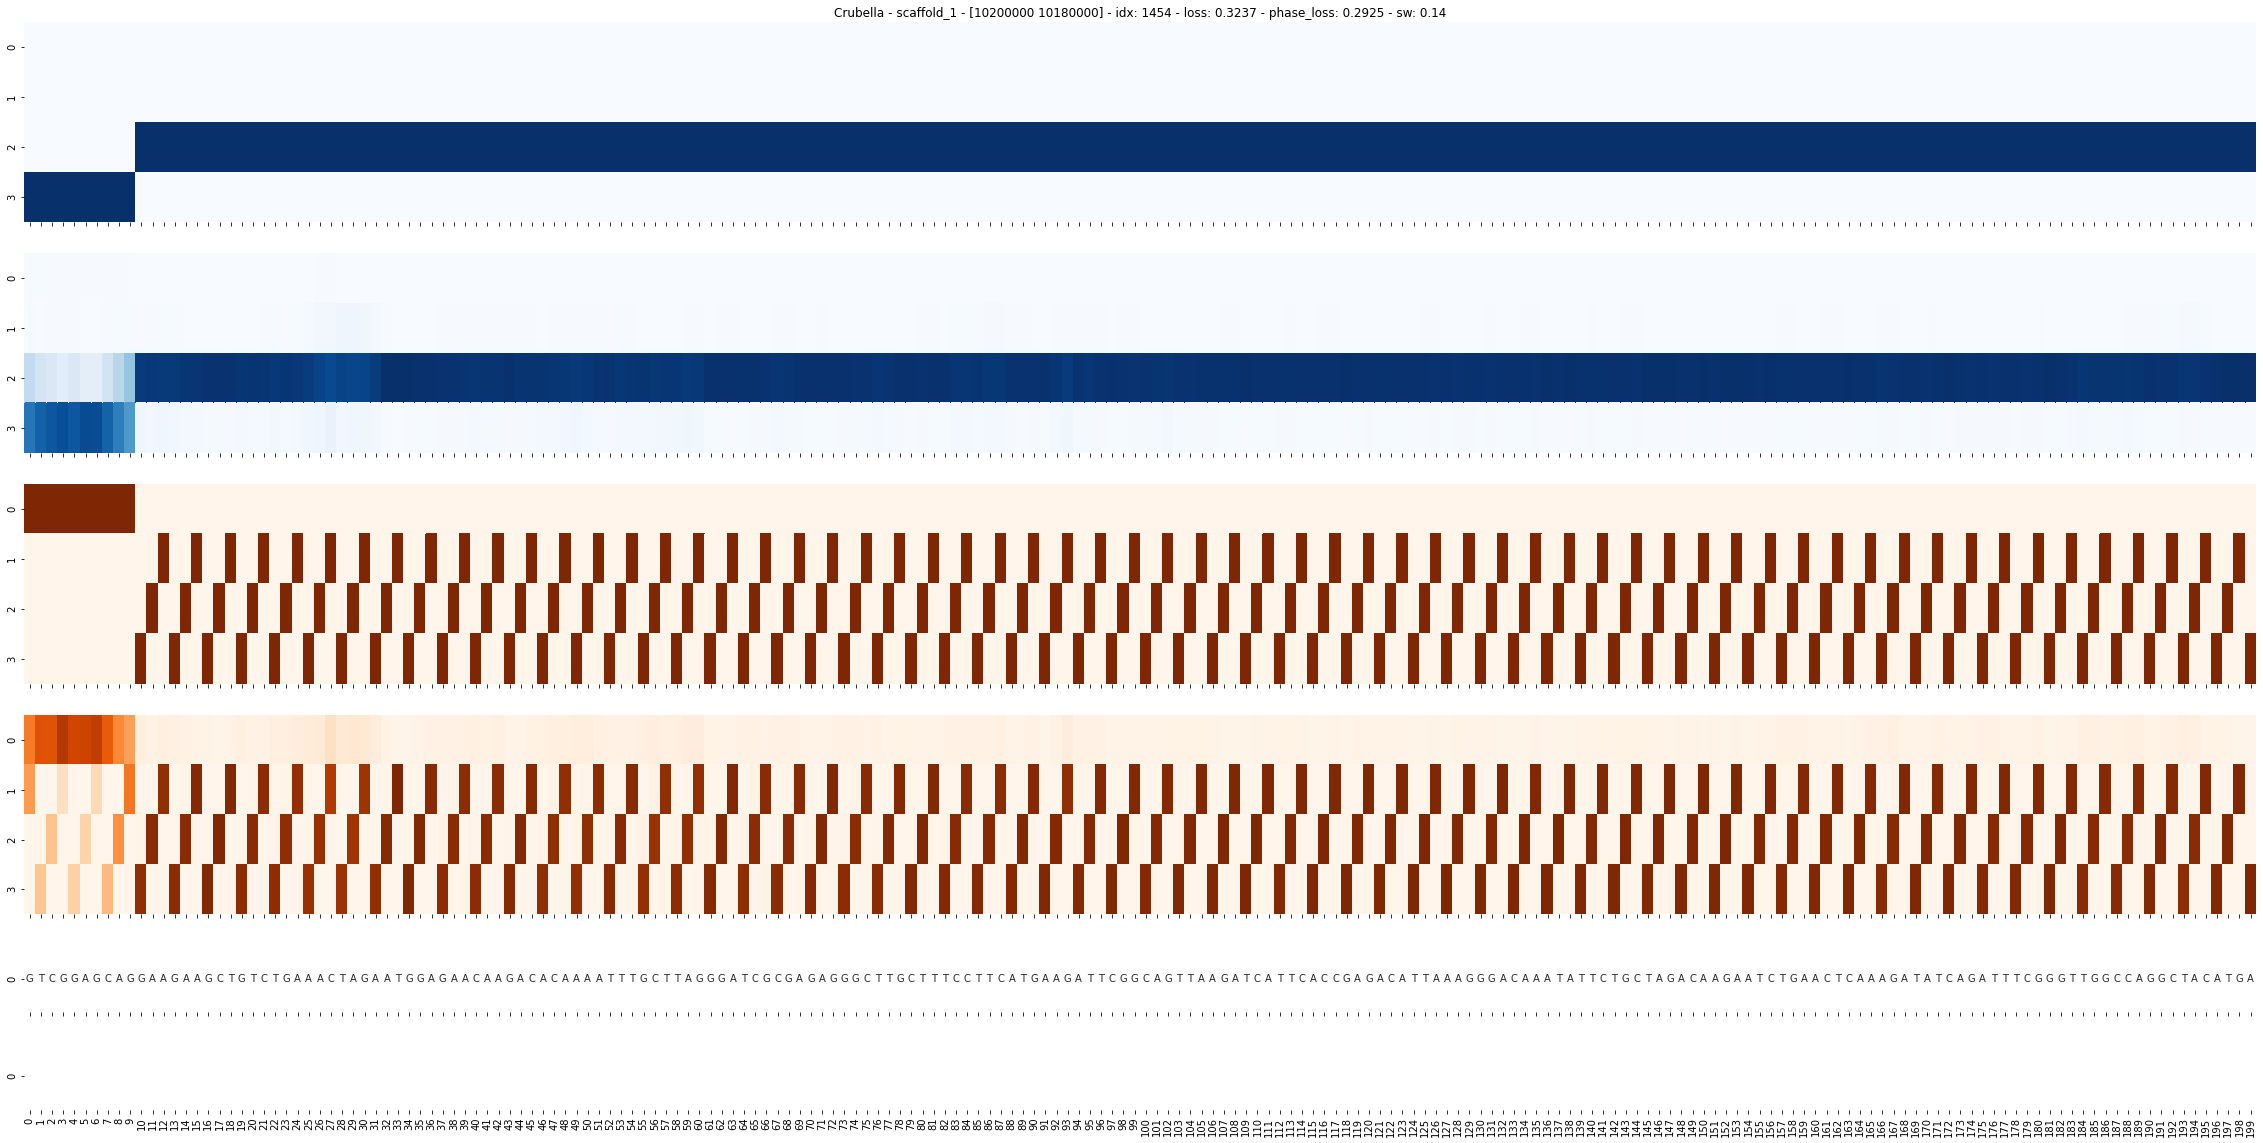

In [139]:
# species_name = 'Gmax'
# idx = loss_phase_idxs['all'][-(np.random.randint(100 + 1))]  # choose sample from the 1000 with the highest loss
idx = loss_idxs['all'][np.random.randint(y_true.shape[0])]  # choose any sample 
range_ = slice(None)

# idx = 8204
# range_ = slice(4100, 4400)

# idx = 5737
# range_ = slice(9200, 9500)

# idx = 4911
# range_ = slice(12350, 12650)

# idx = 2294
# range_ = slice(700, 1200)

idx = 1454
range_ = slice(3500, 3700)

seq_str = [[c for c in dna_sequence(X[idx][range_])]]

fig, axes = plt.subplots(6, figsize=(40, 20), sharex=True, gridspec_kw={'height_ratios': [3, 3, 3, 3, 1, 1]})
axes[0].set_title(f'{species[idx].decode()} - {seqids[idx].decode()} - {start_ends[idx]} - idx: {idx} - loss: {losses[idx]:.4f} - phase_loss: {losses_phase[idx]:.4f} - sw: {frac_sw[idx]:.2f}')
sns.heatmap(y_true[idx, range_].T, cbar=False, cmap='Blues', ax=axes[0])
sns.heatmap(y_pred[idx, range_].T, cbar=False, cmap='Blues', ax=axes[1])
sns.heatmap(y_true_phase[idx, range_].T, cbar=False, cmap='Oranges', ax=axes[2])
sns.heatmap(y_pred_phase[idx, range_].T, cbar=False, cmap='Oranges', ax=axes[3])
sns.heatmap(np.zeros((len(y_true[0, range_]), 1)).T, annot=seq_str, fmt='', cmap=['White'], cbar=False, ax=axes[4])
sns.heatmap(sw[idx, range_][:, None].T, cbar=False, cmap=cmap, norm=norm, ax=axes[5])

In [26]:
dna_sequence(X[idx][range_]
print(idx)

352056
